In [1]:
!pip install scikit-learn dotenv seaborn numpy matplotlib skyfield pandas tqdm


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [2]:
import os 
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
import os
from skyfield.api import Topos
import json
from skyfield.api import load, wgs84, EarthSatellite, Topos
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import math

In [3]:
load_dotenv()

# Parse user location from .env
latitude = float(os.getenv('LATITUDE'))
longitude = float(os.getenv('LONGITUDE'))
elevation = float(os.getenv('ELEVATION'))

In [4]:
base_path = "output"

# Load connection periods
conn_path = f"{base_path}/connection_periods.csv"
if not os.path.exists(conn_path):
    print("Could not find connection_periods.csv")
else:
    df_conn_periods = pd.read_csv(conn_path)

# Load serving satellite data
serving_path = f"{base_path}/combined_serving_satellite.csv"
if not os.path.exists(serving_path):
    print("Could not find combined_serving_satellite.csv")
else:
    df_serving_satellite = pd.read_csv(serving_path)

# load the ping data ping_data.csv
ping_path = f"{base_path}/ping_data.csv"
if not os.path.exists(ping_path):
    print("Could not find ping_data.csv")
else:
    df_ping_data = pd.read_csv(ping_path)
# Load handover visibility JSON
handover_path = f"{base_path}/reconfiguration_visibility.json"
if not os.path.exists(handover_path):
    print("Could not find handover_visibility.json")
else:
    with open(handover_path, 'r') as f:
        handover_visibility = json.load(f)



In [5]:
print(f"df_conn_periods.columns: {df_conn_periods.columns}")
print(f"df_serving_satellite.columns: {df_serving_satellite.columns}")
print(f"df_ping_data.columns: {df_ping_data.columns}")

# first and last row
print(df_conn_periods.iloc[0])
print(df_conn_periods.iloc[-1])
print(df_serving_satellite.iloc[0])
print(df_serving_satellite.iloc[-1])
print(df_ping_data.iloc[0])
print(df_ping_data.iloc[-1])


print(f"handover_visibility.keys(): {handover_visibility.keys()}")


df_conn_periods.columns: Index(['Satellite', 'Start_Time', 'End_Time', 'Duration_Seconds',
       'Mean_Altitude_km', 'TLE_Line1', 'TLE_Line2', 'TLE_Timestamp'],
      dtype='object')
df_serving_satellite.columns: Index(['Timestamp', 'Connected_Satellite', 'Distance', 'TLE_Line1',
       'TLE_Line2', 'TLE_Timestamp', 'Altitude_km', 'timestamp', 'Y', 'X',
       'hardwareVersion', 'sinr', 'popPingLatencyMs', 'downlinkThroughputBps',
       'uplinkThroughputBps', 'tiltAngleDeg', 'boresightAzimuthDeg',
       'boresightElevationDeg', 'attitudeUncertaintyDeg',
       'desiredBoresightAzimuthDeg', 'desiredBoresightElevationDeg',
       'quaternion_qScalar', 'quaternion_qX', 'quaternion_qY', 'quaternion_qZ',
       'lat', 'lon', 'alt', 'Elevation', 'Azimuth'],
      dtype='object')
df_ping_data.columns: Index(['timestamp', 'time_ms', 'latency_ms'], dtype='object')
Satellite                                               STARLINK-2460
Start_Time                                  2025-05-31 17:0

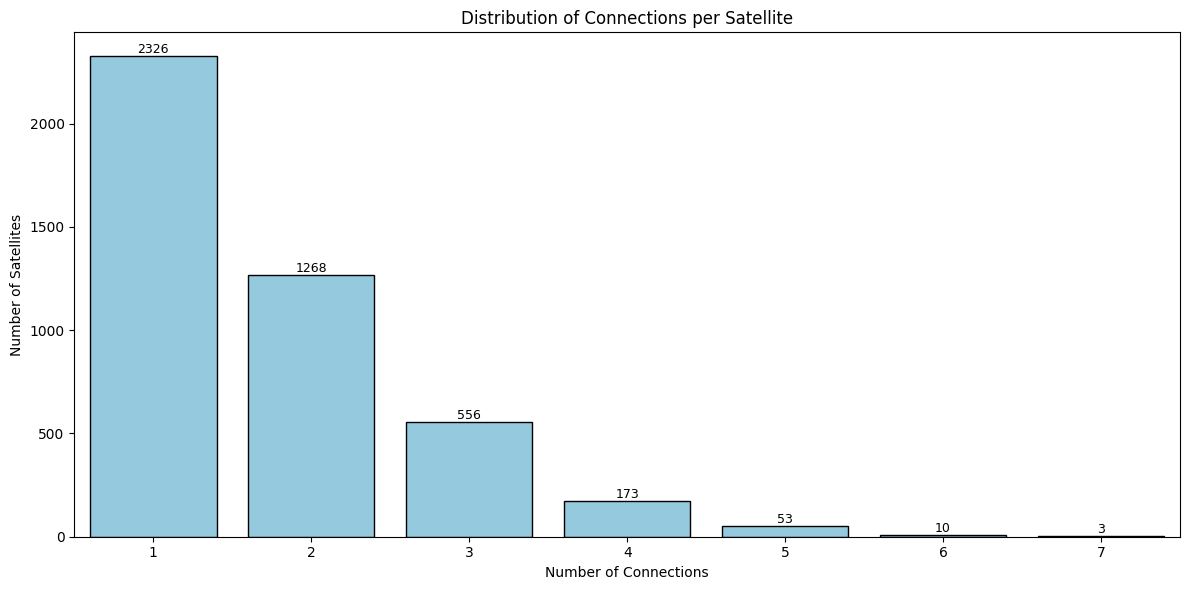

In [6]:
# Get count of satellites by number of connections
connection_distribution = df_conn_periods['Satellite'].value_counts().value_counts().sort_index()

plt.figure(figsize=(12, 6))
ax = sns.barplot(x=connection_distribution.index, y=connection_distribution.values, color='skyblue', edgecolor='black')

# Label each bar
for i, v in enumerate(connection_distribution.values):
    ax.text(i, v + 0.5, str(v), ha='center', va='bottom', fontsize=9)

plt.xlabel('Number of Connections')
plt.ylabel('Number of Satellites')
plt.title('Distribution of Connections per Satellite')
plt.tight_layout()
plt.show()

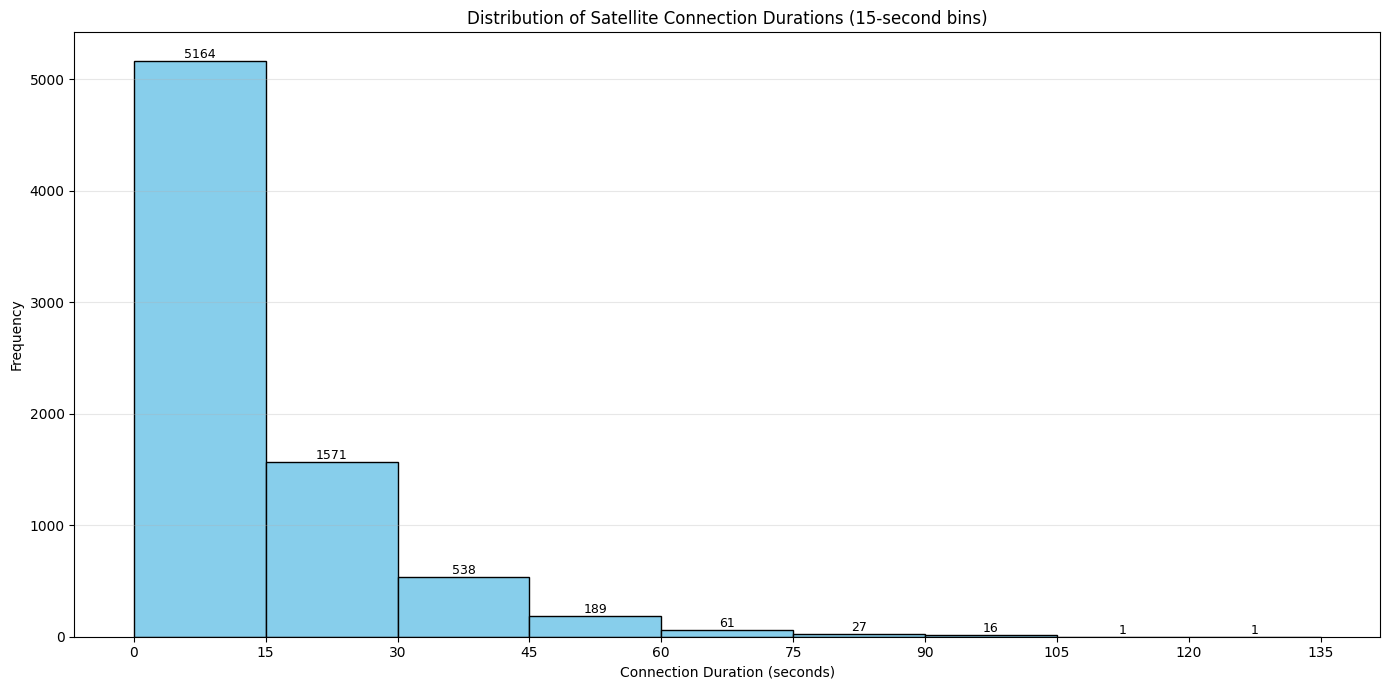

In [7]:
import matplotlib.pyplot as plt
import numpy as np

durations_filtered = df_conn_periods['Duration_Seconds']

# Define bins divisible by 15 seconds from min to max duration
min_dur = 0
max_dur = np.ceil(durations_filtered.max() / 15) * 15
bins = np.arange(min_dur, max_dur + 15, 15)  # bins edges: 0,15,30,...

# Histogram counts and bin edges
counts, bin_edges = np.histogram(durations_filtered, bins=bins)

plt.figure(figsize=(14, 7))
bars = plt.bar(bin_edges[:-1], counts, width=15, color='skyblue', edgecolor='black', align='edge')

plt.xlabel('Connection Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Satellite Connection Durations (15-second bins)')
plt.xticks(bin_edges)  # show all bin edges as x ticks
plt.grid(True, alpha=0.3, axis='y')

# Label bars on top
for bar in bars:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()



In [8]:

# Get unique satellite names and their connection counts
satellite_names = df_conn_periods['Satellite'].unique()
satellite_names = [name for name in satellite_names if name != '']
print(f"Number of unique satellite names: {len(satellite_names)}")


# Get top 10 most frequently seen satellites
satellite_counts = df_conn_periods['Satellite'].value_counts()
satellite_counts = satellite_counts[satellite_counts.index != '']
top_10_satellites = satellite_counts.head(10)

# For each top satellite, show connection durations
print("\nTop 10 satellites and their connection durations:")
for satellite in top_10_satellites.index:
    satellite_data = df_conn_periods[df_conn_periods['Satellite'] == satellite]
    print(f"\n{satellite} (seen {top_10_satellites[satellite]} times):")
    print(satellite_data[['Start_Time', 'End_Time', 'Duration_Seconds']].to_string(index=False))

Number of unique satellite names: 4389

Top 10 satellites and their connection durations:

STARLINK-2563 (seen 7 times):
               Start_Time                  End_Time  Duration_Seconds
2025-06-01 01:11:12+00:00 2025-06-01 01:11:26+00:00              14.0
2025-06-01 06:10:27+00:00 2025-06-01 06:10:56+00:00              29.0
2025-06-01 06:11:42+00:00 2025-06-01 06:11:56+00:00              14.0
2025-06-02 01:04:27+00:00 2025-06-02 01:05:11+00:00              44.0
2025-06-02 01:05:27+00:00 2025-06-02 01:05:41+00:00              14.0
2025-06-02 04:24:57+00:00 2025-06-02 04:25:11+00:00              14.0
2025-06-02 06:03:42+00:00 2025-06-02 06:03:56+00:00              14.0

STARLINK-2270 (seen 7 times):
               Start_Time                  End_Time  Duration_Seconds
2025-05-31 21:43:27+00:00 2025-05-31 21:43:56+00:00              29.0
2025-06-01 02:44:57+00:00 2025-06-01 02:45:11+00:00              14.0
2025-06-01 21:36:12+00:00 2025-06-01 21:36:26+00:00              14.0
2025-06-

/tmp/ipykernel_11274/2973212434.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(start_hours, 1, 'bo', markersize=16, marker='x')  # Blue for start
/tmp/ipykernel_11274/2973212434.py:24: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  plt.plot(end_hours, 1, 'ro', markersize=16, marker='+')    # Red  plus for end


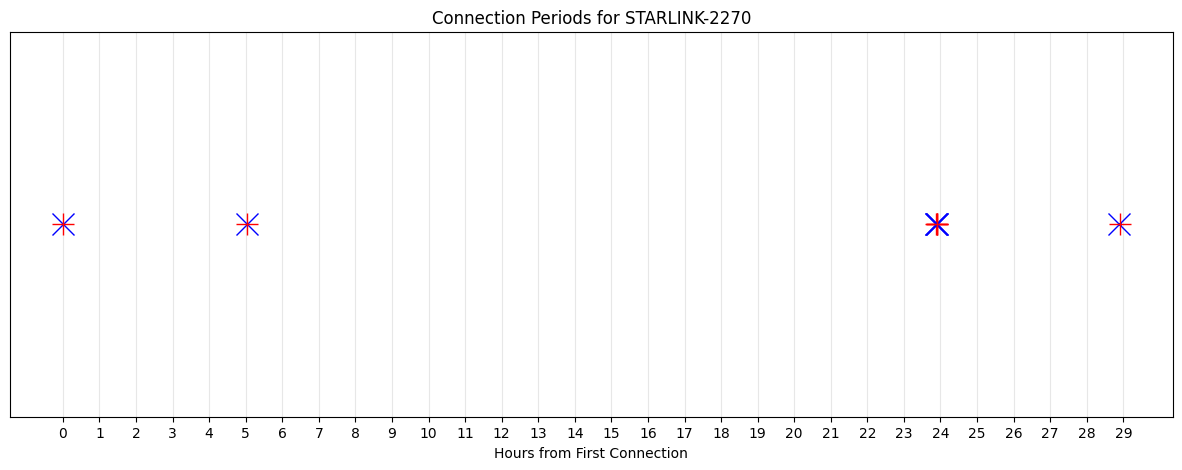

In [9]:
sat = "STARLINK-2270"

# Filter data for this satellite and create a copy to avoid SettingWithCopyWarning
sat_data = df_conn_periods[df_conn_periods['Satellite'] == sat].copy()

# Convert timestamp columns to datetime if they aren't already
sat_data['Start_Time'] = pd.to_datetime(sat_data['Start_Time'])
sat_data['End_Time'] = pd.to_datetime(sat_data['End_Time'])

# Create figure
plt.figure(figsize=(15, 5))

# Plot connection periods as horizontal lines
for idx, row in sat_data.iterrows():
    # Convert timestamps to hours from start
    start_hours = (row['Start_Time'] - sat_data['Start_Time'].min()).total_seconds() / 3600
    end_hours = (row['End_Time'] - sat_data['Start_Time'].min()).total_seconds() / 3600
    
    # Plot horizontal line for this connection period
    plt.plot([start_hours, end_hours], [1, 1], 'b-', linewidth=2)
    
    # Add markers at start and end
    plt.plot(start_hours, 1, 'bo', markersize=16, marker='x')  # Blue for start
    plt.plot(end_hours, 1, 'ro', markersize=16, marker='+')    # Red  plus for end 

plt.title(f'Connection Periods for {sat}')
plt.xlabel('Hours from First Connection')
plt.yticks([])  # Hide y-axis ticks since we only have one line
plt.grid(True, alpha=0.3)

# Set x-axis ticks to show hours
max_hours = (sat_data['End_Time'].max() - sat_data['Start_Time'].min()).total_seconds() / 3600
plt.xticks(np.arange(0, max_hours + 1, 1))  # Show ticks every hour

plt.show()

In [10]:

# Get unique satellite names and their connection counts
satellite_names = df_conn_periods['Satellite'].unique()
satellite_names = [name for name in satellite_names if name != '']
print(f"Number of unique satellite names: {len(satellite_names)}")


# Get top 10 most frequently seen satellites
satellite_counts = df_conn_periods['Satellite'].value_counts()
satellite_counts = satellite_counts[satellite_counts.index != '']
top_10_satellites = satellite_counts.tail(10)

# For each top satellite, show connection durations
print("\nTop 10 satellites and their connection durations:")
for satellite in top_10_satellites.index:
    satellite_data = df_conn_periods[df_conn_periods['Satellite'] == satellite]
    print(f"\n{satellite} (seen {top_10_satellites[satellite]} times):")
    print(satellite_data[['Start_Time', 'End_Time', 'Duration_Seconds']].to_string(index=False))

Number of unique satellite names: 4389

Top 10 satellites and their connection durations:

STARLINK-31522 (seen 1 times):
               Start_Time                  End_Time  Duration_Seconds
2025-06-02 17:55:57+00:00 2025-06-02 17:56:11+00:00              14.0

STARLINK-30518 (seen 1 times):
               Start_Time                  End_Time  Duration_Seconds
2025-06-02 17:54:27+00:00 2025-06-02 17:55:56+00:00              89.0

STARLINK-4517 (seen 1 times):
               Start_Time                  End_Time  Duration_Seconds
2025-06-02 17:50:42+00:00 2025-06-02 17:50:56+00:00              14.0

STARLINK-2714 (seen 1 times):
               Start_Time                  End_Time  Duration_Seconds
2025-06-02 17:49:42+00:00 2025-06-02 17:50:26+00:00              44.0

STARLINK-4097 (seen 1 times):
               Start_Time                  End_Time  Duration_Seconds
2025-06-02 17:44:42+00:00 2025-06-02 17:44:56+00:00              14.0

STARLINK-6162 (seen 1 times):
               Start_T

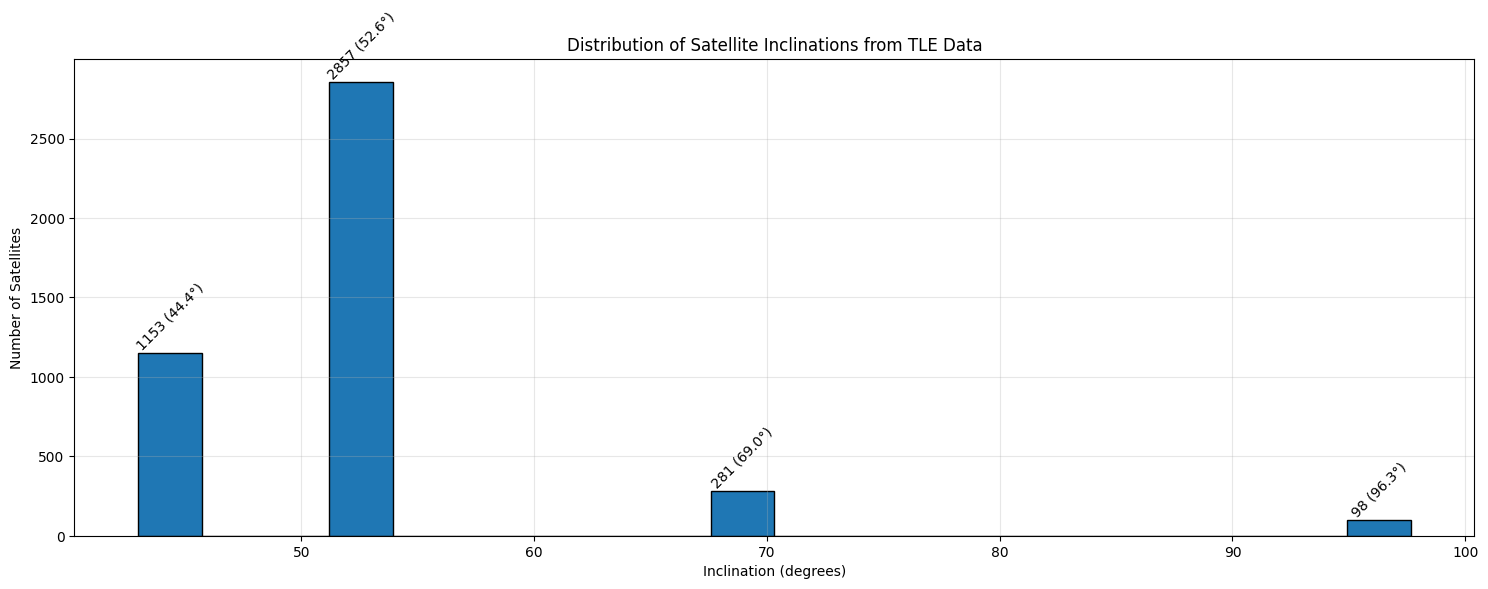


Inclination Statistics:
Mean: 52.56°
Median: 53.16°
Std Dev: 9.44°


In [24]:
# Calculate inclination for each serving satellite from TLE data
satellite_inclinations = []

for satellite in satellite_names:
    satellite_data = df_conn_periods[df_conn_periods['Satellite'] == satellite]
    
    if not satellite_data.empty:
        tle_line2 = satellite_data.iloc[0]['TLE_Line2']
        inclination = float(tle_line2[8:16])
        satellite_inclinations.append(inclination)

plt.figure(figsize=(15, 6))
n, bins, patches = plt.hist(satellite_inclinations, bins=20, edgecolor='black')

for i in range(len(patches)):
    center = (bins[i] + bins[i+1]) / 2
    if n[i] > 0:
        plt.text(center, n[i], f'{int(n[i])} ({center:.1f}°)', 
                ha='center', va='bottom')

plt.xlabel('Inclination (degrees)')
plt.ylabel('Number of Satellites')
plt.title('Distribution of Satellite Inclinations from TLE Data')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nInclination Statistics:")
print(f"Mean: {np.mean(satellite_inclinations):.2f}°")
print(f"Median: {np.median(satellite_inclinations):.2f}°")
print(f"Std Dev: {np.std(satellite_inclinations):.2f}°")

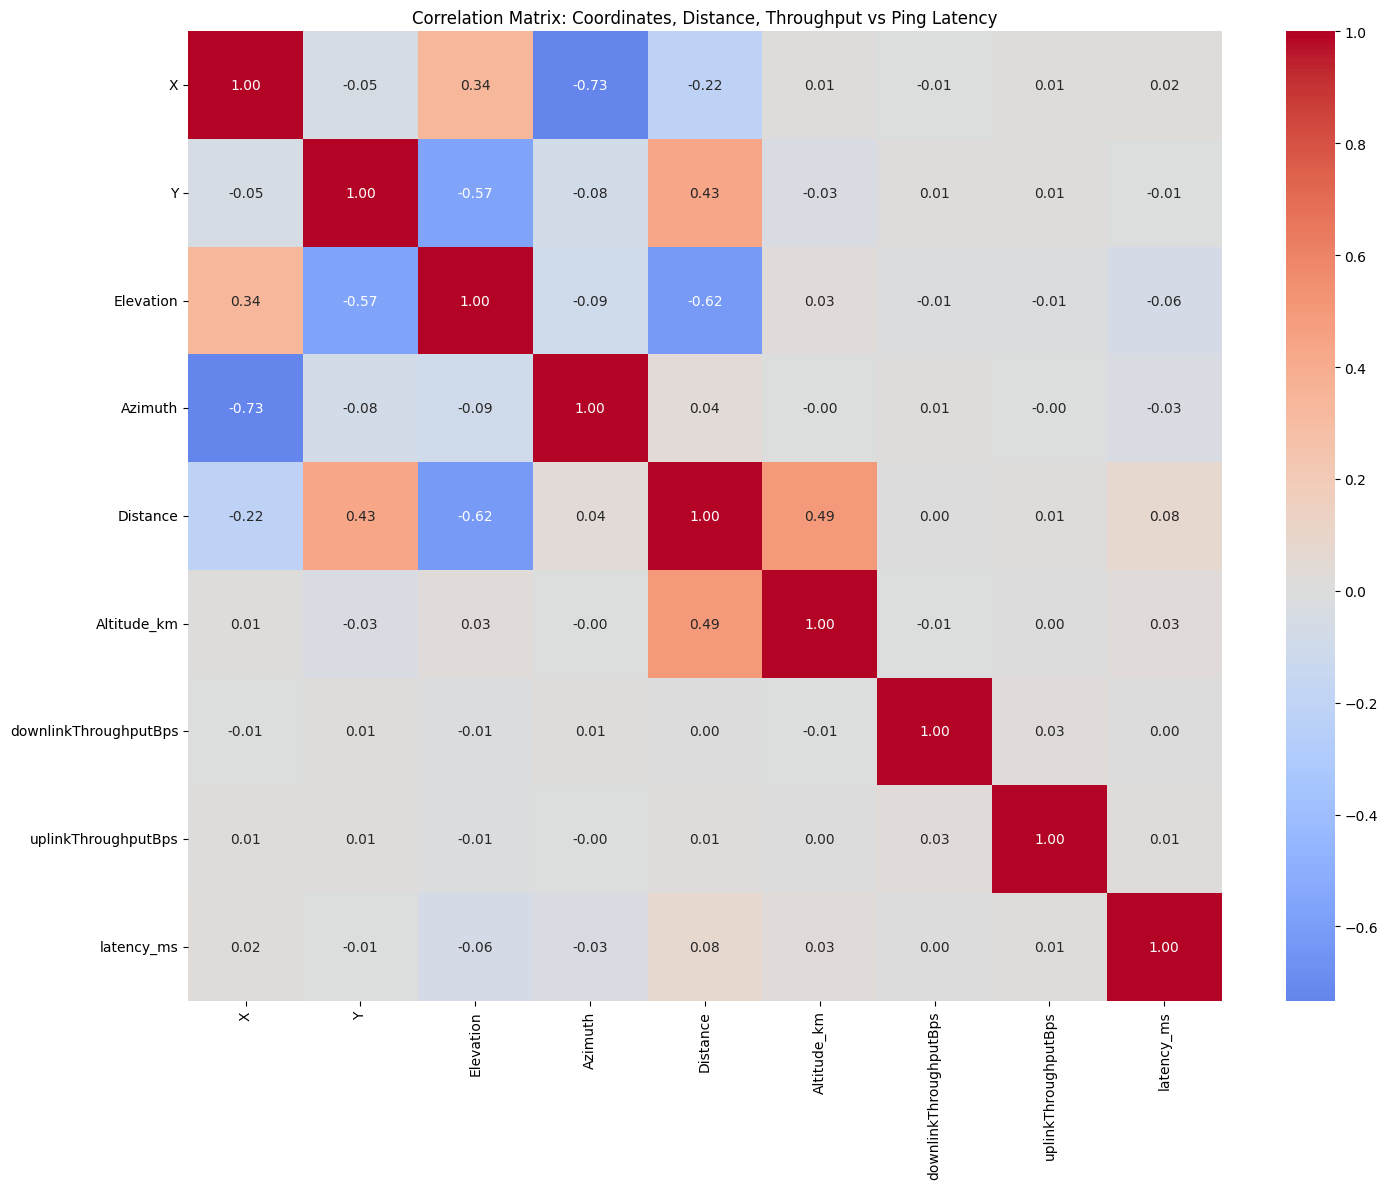

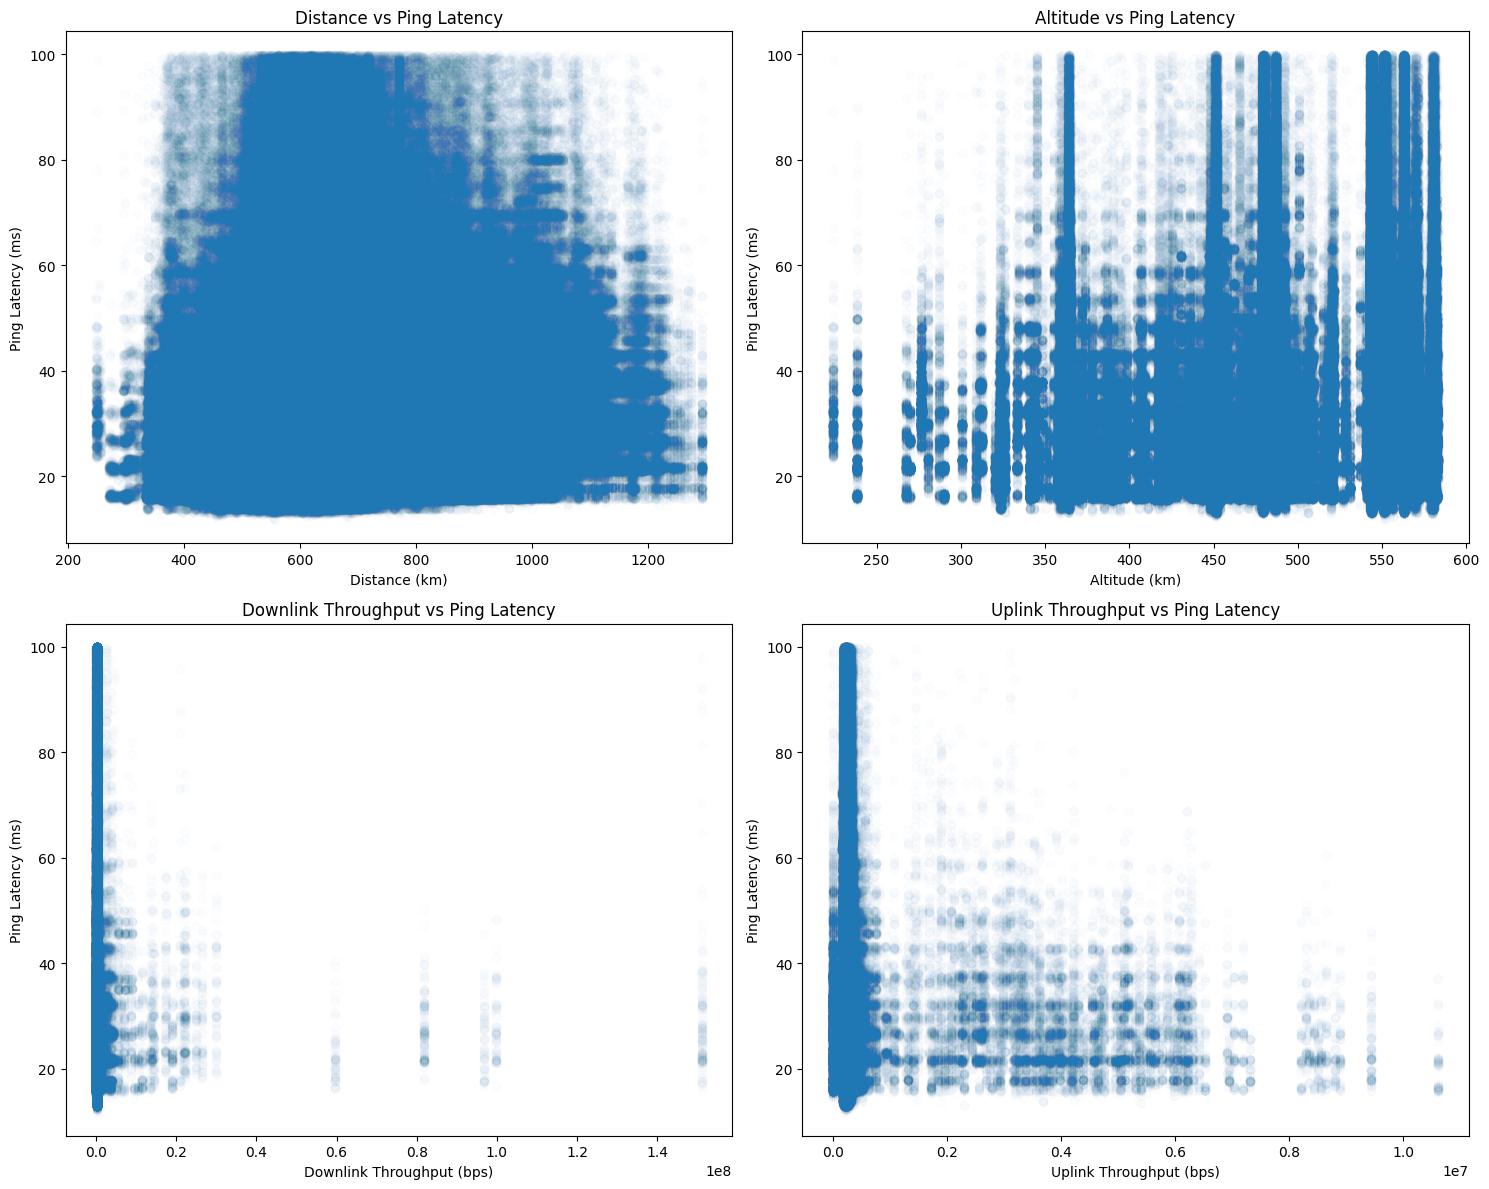


Correlation Coefficients:
Distance vs Ping Latency: 0.078
Altitude vs Ping Latency: 0.028
Downlink Throughput vs Ping Latency: 0.003
Uplink Throughput vs Ping Latency: 0.012


In [12]:
# Calculate correlation between coordinates, distance, throughput and ping latency
correlation_metrics = ['X', 'Y', 'Elevation', 'Azimuth', 'Distance', 'Altitude_km', 
                      'downlinkThroughputBps', 'uplinkThroughputBps', 'latency_ms']
correlation_matrix = df_merged[correlation_metrics].corr()

# Create a heatmap of correlations
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation Matrix: Coordinates, Distance, Throughput vs Ping Latency')
plt.tight_layout()
plt.show()

# Create scatter plots to visualize relationships
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

# Distance vs Ping Latency
ax1.scatter(df_merged['Distance'], df_merged['latency_ms'], alpha=0.01)
ax1.set_xlabel('Distance (km)')
ax1.set_ylabel('Ping Latency (ms)')
ax1.set_title('Distance vs Ping Latency')

# Altitude vs Ping Latency
ax2.scatter(df_merged['Altitude_km'], df_merged['latency_ms'], alpha=0.01)
ax2.set_xlabel('Altitude (km)')
ax2.set_ylabel('Ping Latency (ms)')
ax2.set_title('Altitude vs Ping Latency')

# Downlink Throughput vs Ping Latency
ax3.scatter(df_merged['downlinkThroughputBps'], df_merged['latency_ms'], alpha=0.01)
ax3.set_xlabel('Downlink Throughput (bps)')
ax3.set_ylabel('Ping Latency (ms)')
ax3.set_title('Downlink Throughput vs Ping Latency')

# Uplink Throughput vs Ping Latency
ax4.scatter(df_merged['uplinkThroughputBps'], df_merged['latency_ms'], alpha=0.01)
ax4.set_xlabel('Uplink Throughput (bps)')
ax4.set_ylabel('Ping Latency (ms)')
ax4.set_title('Uplink Throughput vs Ping Latency')

plt.tight_layout()
plt.show()

# Print correlation coefficients
print("\nCorrelation Coefficients:")
print(f"Distance vs Ping Latency: {correlation_matrix.loc['Distance', 'latency_ms']:.3f}")
print(f"Altitude vs Ping Latency: {correlation_matrix.loc['Altitude_km', 'latency_ms']:.3f}")
print(f"Downlink Throughput vs Ping Latency: {correlation_matrix.loc['downlinkThroughputBps', 'latency_ms']:.3f}")
print(f"Uplink Throughput vs Ping Latency: {correlation_matrix.loc['uplinkThroughputBps', 'latency_ms']:.3f}")



--- TLE Info ---
TLE Timestamp: 2025-06-01 07:00:00+00:00
TLE Line 1: 1 63761U 25089L   25151.80652892  .00002593  00000+0  17760-4 0  9994
TLE Line 2: 2 63761  42.9978 192.1601 0001831 272.1926  87.8735 15.77860290  5745
Start time: 2025-06-01 07:52:27+00:00, Elevation: 54.27007806484961, Azimuth: 200.35621038266154
End time: 2025-06-01 07:52:56+00:00, Elevation: 53.157495892414296, Azimuth: 149.21436915350077


NameError: name 'time_array' is not defined

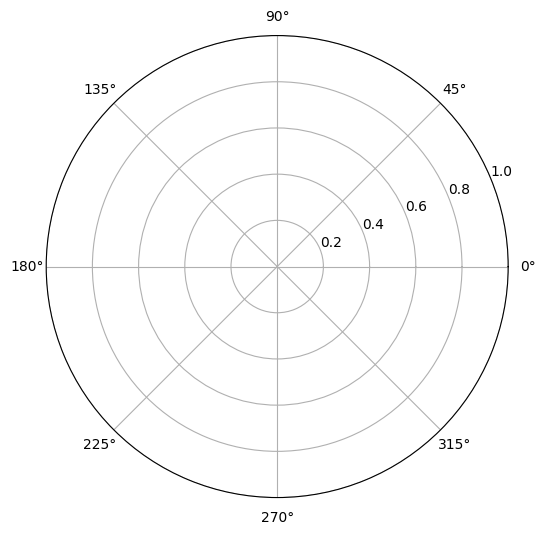

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from skyfield.api import load, EarthSatellite, wgs84
import pandas as pd

ts = load.timescale()
user_location = wgs84.latlon(latitude, longitude, elevation_m=elevation)

# Filter just one satellite RANDOM
random_sat = df_conn_periods['Satellite'].unique()[np.random.randint(0, len(df_conn_periods['Satellite'].unique()))]
single_sat = df_conn_periods[df_conn_periods['Satellite'] == random_sat]

azimuths_start = []
elevations_start = []
azimuths_end = []
elevations_end = []
start_times = []
end_times = []

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)

for _, row in single_sat.iterrows():
    tle_timestamp = row['TLE_Timestamp']
    tle_line1 = row['TLE_Line1']
    tle_line2 = row['TLE_Line2']
    start_time_dt = pd.to_datetime(row['Start_Time'])
    end_time_dt = pd.to_datetime(row['End_Time'])


    print("\n--- TLE Info ---")
    print(f"TLE Timestamp: {tle_timestamp}")
    print(f"TLE Line 1: {tle_line1}")
    print(f"TLE Line 2: {tle_line2}")

    satellite = EarthSatellite(tle_line1, tle_line2, random_sat, ts)

    # Start time
    t_start = ts.from_datetime(start_time_dt)
    topocentric_start = (satellite - user_location).at(t_start)
    alt_start, az_start, _ = topocentric_start.altaz()
    az_start_rad = np.radians(az_start.degrees)
    azimuths_start.append(az_start_rad)
    elevations_start.append(alt_start.degrees)
    start_times.append(start_time_dt.strftime("%H:%M"))

    print(f"Start time: {start_time_dt}, Elevation: {alt_start.degrees}, Azimuth: {az_start.degrees}")

    # End time
    t_end = ts.from_datetime(end_time_dt)
    topocentric_end = (satellite - user_location).at(t_end)
    alt_end, az_end, _ = topocentric_end.altaz()
    az_end_rad = np.radians(az_end.degrees)
    azimuths_end.append(az_end_rad)
    elevations_end.append(alt_end.degrees)
    end_times.append(end_time_dt.strftime("%H:%M"))

    print(f"End time: {end_time_dt}, Elevation: {alt_end.degrees}, Azimuth: {az_end.degrees}")


    # Get azimuths and elevations for all points
    az_list_deg = []
    el_list = []
    
    for t in time_array:
        topo = (satellite - user_location).at(t)
        alt, az, _ = topo.altaz()
        az_list_deg.append(az.degrees)
        el_list.append(alt.degrees)
    
    # Convert to radians and unwrap
    az_list_rad = np.unwrap(np.radians(az_list_deg))

    ax.plot(az_list_rad, el_list, color='green', alpha=0.6, linewidth=1)

# Plot start points
ax.scatter(azimuths_start, elevations_start, c='blue', s=50, label='Start')

# Plot end points
ax.scatter(azimuths_end, elevations_end, c='red', s=50, marker='x', label='End')

# Add labels for start times (small text, slightly offset)
# Format times with full date and time
start_times = [pd.to_datetime(t).strftime("%m:%d:%H:%M:%S") for t in single_sat['Start_Time']]
end_times = [pd.to_datetime(t).strftime("%m:%d:%H:%M:%S") for t in single_sat['End_Time']]


# Add labels for start times (offset to top-right)
for az, el, t_str in zip(azimuths_start, elevations_start, start_times):
    # Offset: +3 degrees elevation, +0.05 radians azimuth to right
    ax.text(az + 0.05, el + 3, t_str, fontsize=7, color='blue', ha='left', va='bottom')

# Add labels for end times (offset to top-right)
for az, el, t_str in zip(azimuths_end, elevations_end, end_times):
    # Offset: +3 degrees elevation, +0.05 radians azimuth to right
    ax.text(az + 0.05, el + 3, t_str, fontsize=7, color='red', ha='left', va='bottom')


ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(90, 0)  # 90° center, 0° edge

plt.title(f'Start vs End Positions with TLE Path for {random_sat}')
plt.legend()
plt.show()




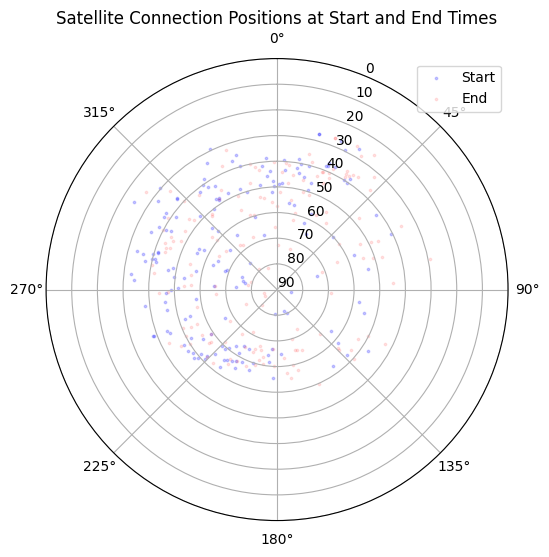

In [47]:
# Ensure timescale and user location are initialized
ts = load.timescale()
user_location = wgs84.latlon(latitude, longitude, elevation_m=elevation)

# Initialize lists for azimuths and elevations at connection start and end
azimuths_start = []
elevations_start = []
azimuths_end = []
elevations_end = []

# Iterate through all rows in the DataFrame
for _, row in df_conn_periods.iterrows():
    tle_line1 = row['TLE_Line1']
    tle_line2 = row['TLE_Line2']
    sat_name = row['Satellite']
    start_time_dt = pd.to_datetime(row['Start_Time'])
    end_time_dt = pd.to_datetime(row['End_Time'])

    # Create satellite object
    satellite = EarthSatellite(tle_line1, tle_line2, sat_name, ts)

    # Compute satellite's position at start time relative to observer
    t_start = ts.from_datetime(start_time_dt)
    topocentric_start = (satellite - user_location).at(t_start)
    alt_start, az_start, _ = topocentric_start.altaz()

    if alt_start.degrees > 0:
        azimuths_start.append(np.radians(az_start.degrees))
        elevations_start.append(alt_start.degrees)

    # Compute satellite's position at end time relative to observer
    t_end = ts.from_datetime(end_time_dt)
    topocentric_end = (satellite - user_location).at(t_end)
    alt_end, az_end, _ = topocentric_end.altaz()

    if alt_end.degrees > 0:
        azimuths_end.append(np.radians(az_end.degrees))
        elevations_end.append(alt_end.degrees)

# Plot as polar
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, polar=True)

# Start times in blue
ax.scatter(azimuths_start, elevations_start, c='blue', s=3, alpha=0.2, label='Start')

# End times in red
ax.scatter(azimuths_end, elevations_end, c='red', s=3, alpha=0.1, label='End')

ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.set_rlim(90, 0)  # Center is zenith, edge is horizon

plt.title('Satellite Connection Positions at Start and End Times')
plt.legend()
plt.show()


In [48]:
outside_rows = []

for i, (timestamp_str, visible_sats) in enumerate(handover_visibility.items()):
    timestamp_dt = pd.to_datetime(timestamp_str)
    row = df_serving_satellite[pd.to_datetime(df_serving_satellite['Timestamp']) == timestamp_dt]

    if row.empty:
        continue

    sat_info = row.iloc[0]
    connected_sat = sat_info['Connected_Satellite']
    tilt = sat_info.get('tiltAngleDeg', 0)
    az_boresight = sat_info.get('boresightAzimuthDeg', 0)

    tle1 = sat_info.get('TLE_Line1')
    tle2 = sat_info.get('TLE_Line2')
    if not tle1 or not tle2:
        continue

    # Load satellite and compute az/el
    ts = load.timescale()
    sat = EarthSatellite(tle1, tle2, connected_sat, ts)
    t = ts.from_datetime(timestamp_dt)
    topocentric = (sat - user_location).at(t)
    alt, az, _ = topocentric.altaz()

    if alt.degrees <= 0:
        continue  # Below horizon

    # Compute rotated coordinates
    r = 90 - alt.degrees 
    theta = math.radians((az.degrees) % 360)
    x = r * math.cos(theta)
    y = r * math.sin(theta)
    x -= tilt

    rot_rad = math.radians(-az_boresight)
    x_rot = x * math.cos(rot_rad) - y * math.sin(rot_rad)
    y_rot = x * math.sin(rot_rad) + y * math.cos(rot_rad)

    base_radius = 55
    x_radius = base_radius
    y_radius = math.sqrt(max(base_radius**2 - tilt**2, 0))

    inside = (x_rot**2 / x_radius**2 + y_rot**2 / y_radius**2) <= 1

    if not inside:
        row_copy = sat_info.copy()
        row_copy['Elevation'] = alt.degrees
        row_copy['Azimuth'] = az.degrees
        row_copy['timestamp'] = timestamp_str  # Changed from Timestamp_str
        row_copy['satellite'] = connected_sat  # Changed from Connected_Satellite
        row_copy['index'] = i  # Changed from Visibility_Index
        outside_rows.append(row_copy)

df_outside_fov = pd.DataFrame(outside_rows)
if not df_outside_fov.empty:
    print(f"{len(df_outside_fov)} entries where the connected satellite was outside the FOV.")
    print(df_outside_fov[['timestamp', 'satellite', 'index']])
else:
    print("No entries found where the connected satellite was outside the FOV.")

50 entries where the connected satellite was outside the FOV.
                      timestamp             satellite  index
300   2025-05-31T17:05:12+00:00        STARLINK-32522     20
555   2025-05-31T17:09:27+00:00         STARLINK-1277     37
570   2025-05-31T17:09:42+00:00         STARLINK-1277     38
585   2025-05-31T17:09:57+00:00  STARLINK-11084 [DTC]     39
600   2025-05-31T17:10:12+00:00  STARLINK-11084 [DTC]     40
615   2025-05-31T17:10:27+00:00  STARLINK-11084 [DTC]     41
675   2025-05-31T17:11:27+00:00         STARLINK-6372     43
630   2025-05-31T17:10:42+00:00  STARLINK-11084 [DTC]     44
705   2025-05-31T17:11:57+00:00        STARLINK-32468     47
720   2025-05-31T17:12:12+00:00        STARLINK-32468     48
855   2025-05-31T17:14:27+00:00         STARLINK-2507     58
960   2025-05-31T17:16:27+00:00         STARLINK-2417     64
990   2025-05-31T17:16:57+00:00        STARLINK-32586     67
1185  2025-05-31T17:20:12+00:00         STARLINK-4051     80
1425  2025-05-31T17:24:

user location WGS84 latitude +44.9911 N longitude -93.2225 E elevation 234.6 m

Serving Satellite Information:
Timestamp: 2025-05-31T17:05:12+00:00
Connected Satellite: STARLINK-32522
Tilt Angle: 25.37°
Boresight Azimuth: 8.49°
Elevation: 71.44°
Azimuth: 232.53°
TLE Line 1: 1 61981U 24210Y   25151.23954979  .00030623  00000+0  11160-2 0  9990
TLE Line 2: 2 61981  43.0014 334.8855 0001231 280.7542  79.3171 15.27630669 31771
Satellite at az 58.99°, elev 32.67° is inside FOV
Satellite at az 332.20°, elev 48.89° is inside FOV
Satellite at az 322.47°, elev 27.48° is inside FOV
Satellite at az 253.09°, elev 22.59° is inside FOV
Satellite at az 13.76°, elev 34.21° is inside FOV
Satellite at az 110.68°, elev 60.86° is inside FOV
Satellite at az 311.05°, elev 53.87° is inside FOV
Satellite at az 269.69°, elev 40.04° is inside FOV
Satellite at az 168.70°, elev 66.95° is inside FOV
Satellite at az 313.95°, elev 26.69° is inside FOV
Satellite at az 326.19°, elev 28.00° is inside FOV
Satellite at a

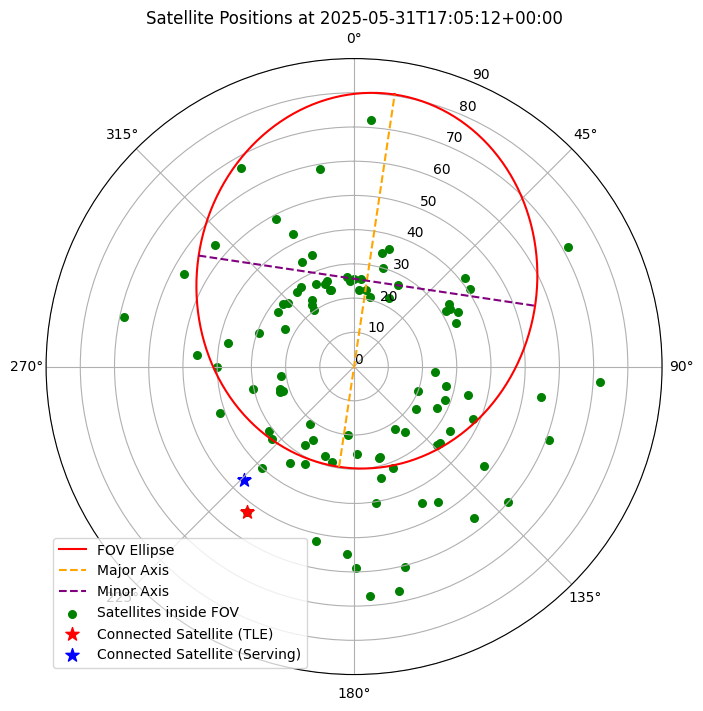

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from skyfield.api import EarthSatellite, load

print(f"user location {user_location}")
index = 20
timestamp_str = list(handover_visibility.keys())[index]
timestamp_dt = pd.to_datetime(timestamp_str)
satellites = handover_visibility[timestamp_str]

row = df_serving_satellite[pd.to_datetime(df_serving_satellite['Timestamp']) == timestamp_dt]
connected_sat = row.iloc[0]['Connected_Satellite'] if not row.empty else None
row_sat = df_serving_satellite[
    (pd.to_datetime(df_serving_satellite['Timestamp']) == timestamp_dt) & 
    (df_serving_satellite['Connected_Satellite'] == connected_sat)
]

if not row_sat.empty:
    sat_info = row_sat.iloc[0]
    print("\nServing Satellite Information:")
    print(f"Timestamp: {timestamp_str}")
    print(f"Connected Satellite: {connected_sat}")
    print(f"Tilt Angle: {sat_info.get('tiltAngleDeg', 'N/A'):.2f}°")
    print(f"Boresight Azimuth: {sat_info.get('boresightAzimuthDeg', 'N/A'):.2f}°")
    print(f"Elevation: {sat_info.get('Elevation', 'N/A'):.2f}°")
    print(f"Azimuth: {sat_info.get('Azimuth', 'N/A'):.2f}°")
    print(f"TLE Line 1: {sat_info.get('TLE_Line1', 'N/A')}")
    print(f"TLE Line 2: {sat_info.get('TLE_Line2', 'N/A')}")

    tiltAngleDeg = sat_info.get('tiltAngleDeg', 0)
    boresightAzimuthDeg = sat_info.get('boresightAzimuthDeg', 0)
    tle_line1 = sat_info.get('TLE_Line1')
    tle_line2 = sat_info.get('TLE_Line2')
else:
    print(f"\n[!] No information found for satellite '{connected_sat}' at {timestamp_str}")
    tiltAngleDeg, boresightAzimuthDeg = 0, 0
    tle_line1, tle_line2 = None, None

# === PLOT SETUP ===
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, polar=True)
ax.set_ylim(0, 90)
ax.set_yticks(np.arange(0, 91, 10))
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.grid(True)

base_radius = 55
tilt_rad = math.radians(tiltAngleDeg)
az_rad = math.radians(boresightAzimuthDeg)

# Compute major (along tilt direction) and minor axes (perpendicular to tilt)
major_radius = base_radius
minor_radius = base_radius * math.cos(tilt_rad)  # compressed due to tilt

# Parametrize ellipse
phi = np.linspace(0, 2 * np.pi, 300)
x = major_radius * np.cos(phi)
y = minor_radius * np.sin(phi)

# Rotate ellipse to match boresight azimuth
x_rot = x * np.cos(az_rad) - y * np.sin(az_rad)
y_rot = x * np.sin(az_rad) + y * np.cos(az_rad)

# Center ellipse at boresight (polar coordinates → cartesian)
bore_r = tiltAngleDeg  # Changed: now using tilt angle directly
bore_x = bore_r * np.cos(az_rad)
bore_y = bore_r * np.sin(az_rad)
x_rot += bore_x
y_rot += bore_y

# Convert to polar for plotting
r = np.sqrt(x_rot**2 + y_rot**2)
theta = np.arctan2(y_rot, x_rot)
ax.plot(theta, r, 'r', label='FOV Ellipse')

# === Plot major axis ===
maj_x = np.array([-major_radius, major_radius])
maj_y = np.array([0, 0])
maj_x_rot = maj_x * np.cos(az_rad) - maj_y * np.sin(az_rad) + bore_x
maj_y_rot = maj_x * np.sin(az_rad) + maj_y * np.cos(az_rad) + bore_y
r_maj = np.sqrt(maj_x_rot**2 + maj_y_rot**2)
theta_maj = np.arctan2(maj_y_rot, maj_x_rot)
ax.plot(theta_maj, r_maj, 'orange', linestyle='--', label='Major Axis')

# === Plot minor axis ===
min_x = np.array([0, 0])
min_y = np.array([-minor_radius, minor_radius])
min_x_rot = min_x * np.cos(az_rad) - min_y * np.sin(az_rad) + bore_x
min_y_rot = min_x * np.sin(az_rad) + min_y * np.cos(az_rad) + bore_y
r_min = np.sqrt(min_x_rot**2 + min_y_rot**2)
theta_min = np.arctan2(min_y_rot, min_x_rot)
ax.plot(theta_min, r_min, 'purple', linestyle='--', label='Minor Axis')

# === Plot satellites in FOV === #
for sat in satellites:
    elev = sat['sat_elevation_deg']
    az_deg = sat['sat_azimuth_deg'] % 360
    r = elev  # Changed: now using elevation directly
    az = np.radians(az_deg)
    ax.scatter(az, r, c='green', s=30, label='Satellites inside FOV' if sat == satellites[0] else "")
    print(f"Satellite at az {az_deg:.2f}°, elev {elev:.2f}° is inside FOV")

# === Plot connected satellite using TLE data ===
if tle_line1 and tle_line2:
    ts = load.timescale()
    satellite = EarthSatellite(tle_line1, tle_line2, connected_sat, ts)
    t = ts.from_datetime(timestamp_dt)
    topocentric = (satellite - user_location).at(t)
    alt, az, _ = topocentric.altaz()

    if alt.degrees > 0:
        az_deg = (az.degrees) % 360
        r = alt.degrees  # Changed: now using altitude directly
        az_rad = np.radians(az_deg)
        ax.scatter(az_rad, r, c='red', s=100, marker='*', label='Connected Satellite (TLE)')
        print(f"Connected satellite (TLE) az = {az_deg:.2f}°, el = {alt.degrees:.2f}°")

# === Plot connected satellite using serving data ===
if not row_sat.empty:
    elevation = sat_info.get('Elevation')
    azimuth = sat_info.get('Azimuth')
    if elevation is not None and azimuth is not None:
        az_deg = (azimuth - boresightAzimuthDeg) % 360
        r =  elevation - tiltAngleDeg # Changed: now using elevation directly
        az_rad = np.radians(az_deg)
        ax.scatter(az_rad, r, c='blue', s=100, marker='*', label='Connected Satellite (Serving)')
        print(f"Connected satellite (Serving) az = {az_deg:.2f}°, el = {elevation:.2f}°")

plt.title(f'Satellite Positions at {timestamp_str}')
plt.legend()
plt.show()


Available columns: ['satellite', 'sat_elevation_deg', 'sat_azimuth_deg', 'UT_boresight_elevation', 'UT_boresight_azimuth', 'tle_line1', 'tle_line2']


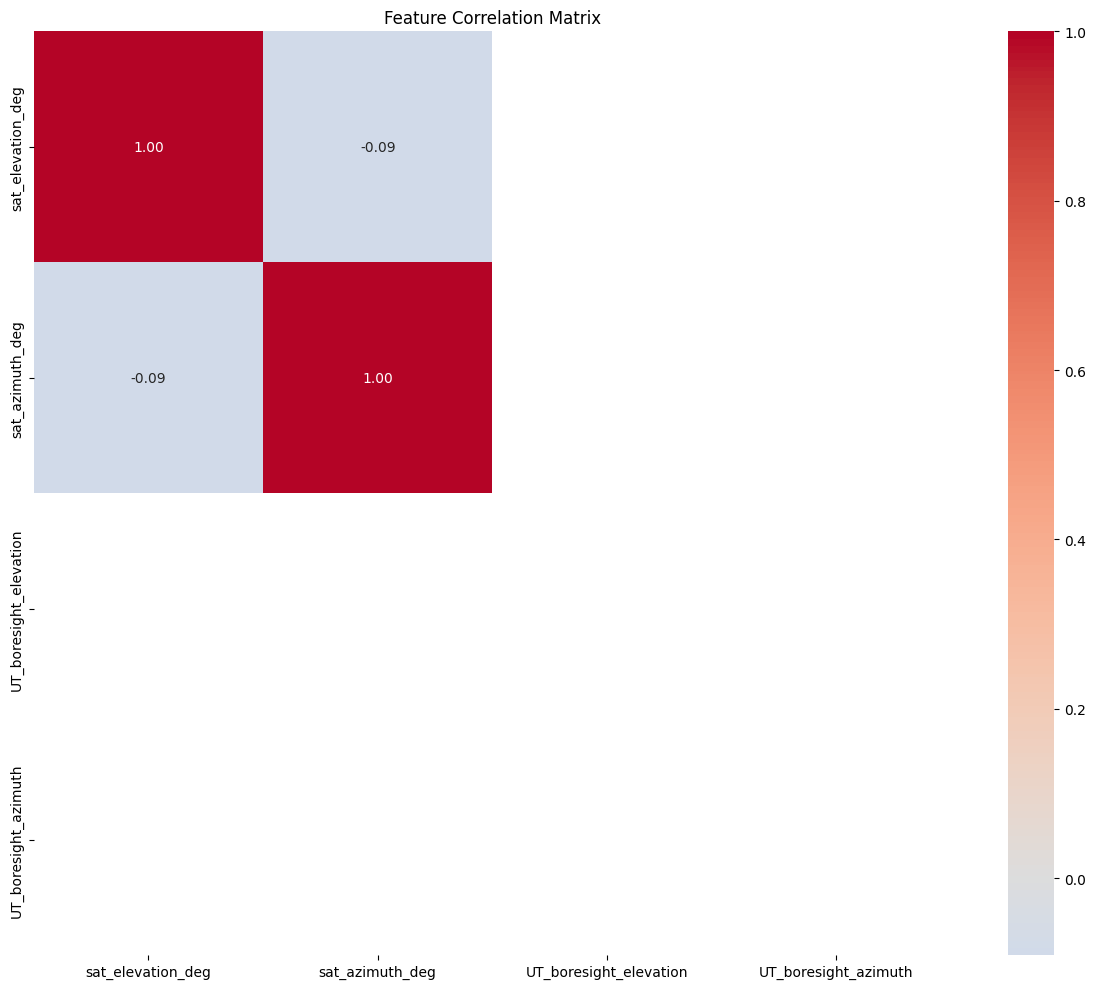


Basic Statistics:
       sat_elevation_deg  sat_azimuth_deg  UT_boresight_elevation  \
count          99.000000        99.000000            9.900000e+01   
mean           36.029918       191.467685            2.536902e+01   
std            14.343961       107.457522            3.570794e-15   
min            20.035696         3.944925            2.536902e+01   
25%            25.683939       110.558995            2.536902e+01   
50%            31.681614       182.092502            2.536902e+01   
75%            42.086605       293.882372            2.536902e+01   
max            72.340021       359.974960            2.536902e+01   

       UT_boresight_azimuth  
count          9.900000e+01  
mean           8.487701e+00  
std            1.785397e-15  
min            8.487701e+00  
25%            8.487701e+00  
50%            8.487701e+00  
75%            8.487701e+00  
max            8.487701e+00  

Pairwise Correlations with P-values:
sat_elevation_deg vs sat_azimuth_deg:
Correlation: 

/tmp/ipykernel_11162/4091552930.py:34: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  correlation, p_value = stats.pearsonr(satellites_df[col1], satellites_df[col2])


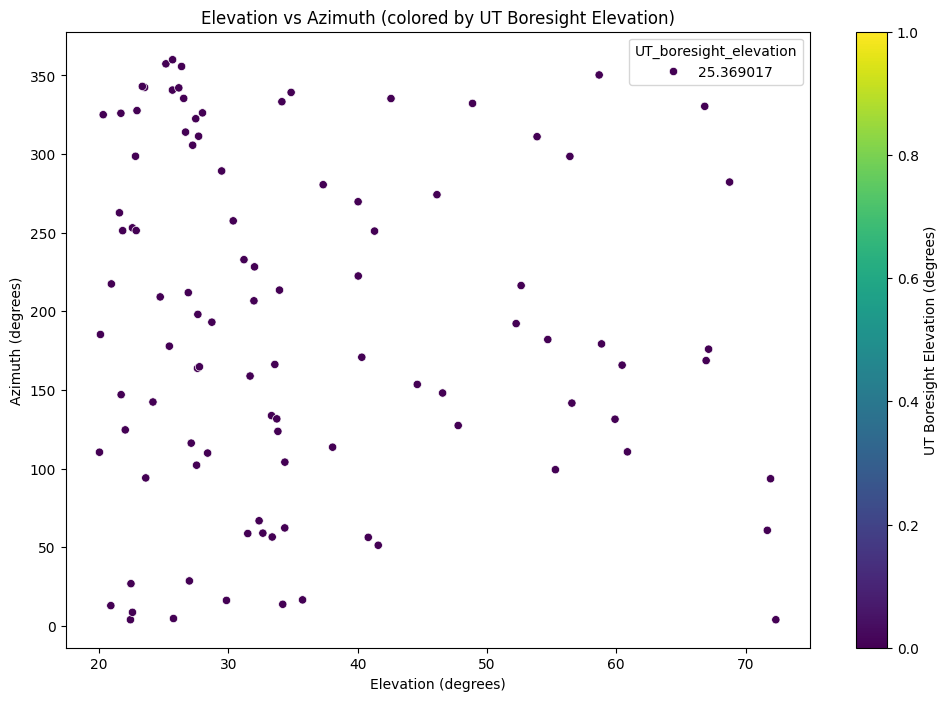

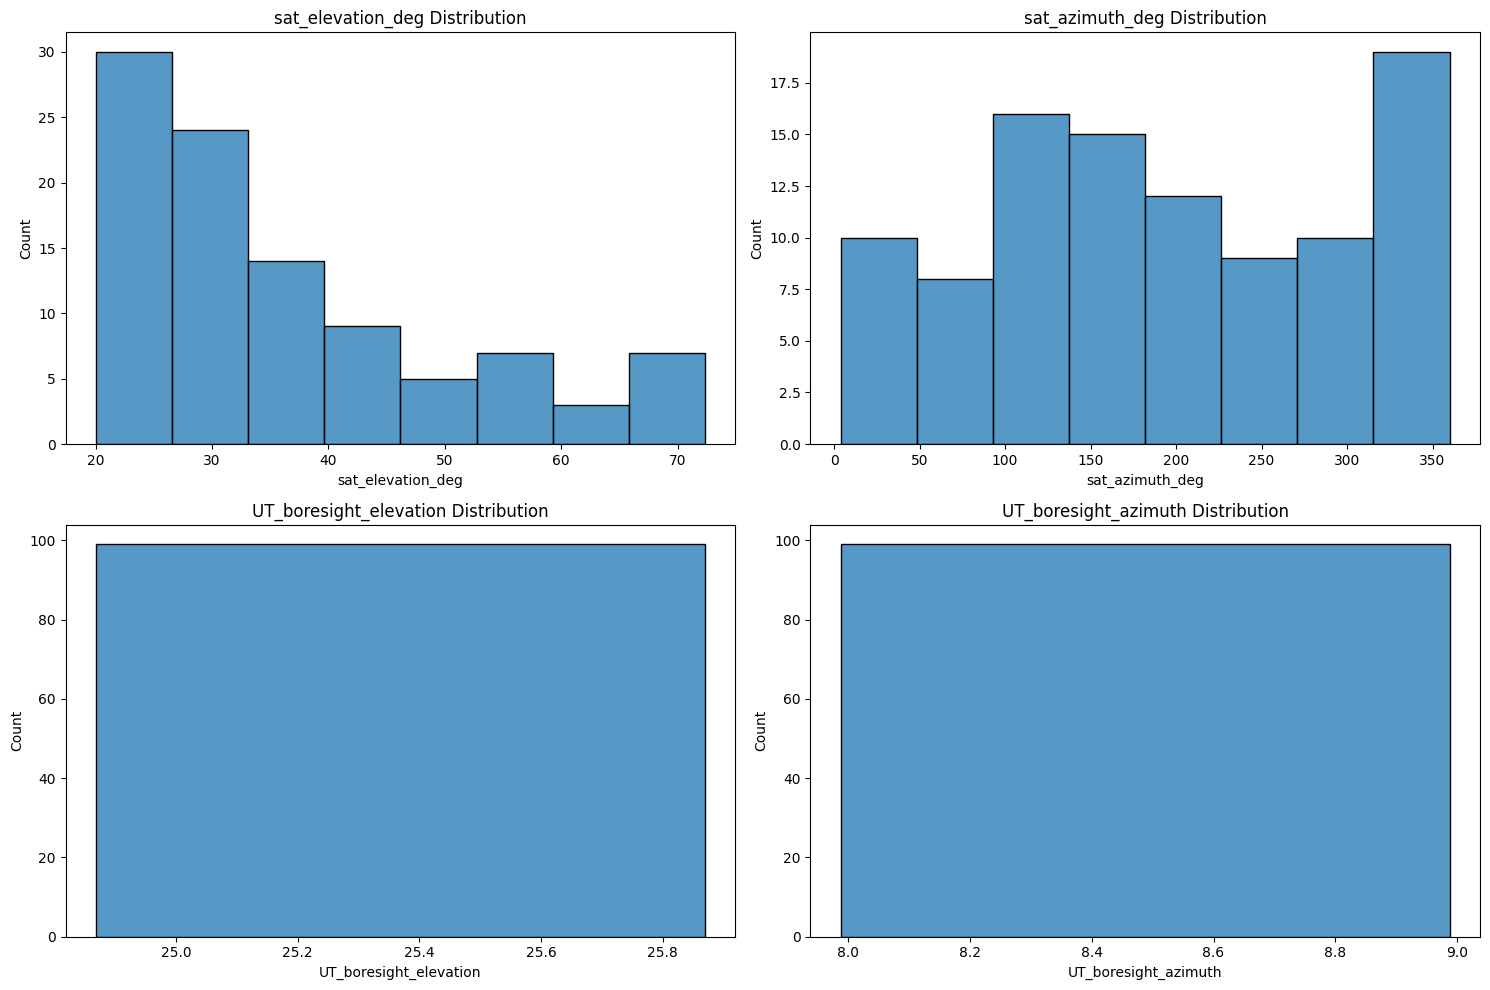

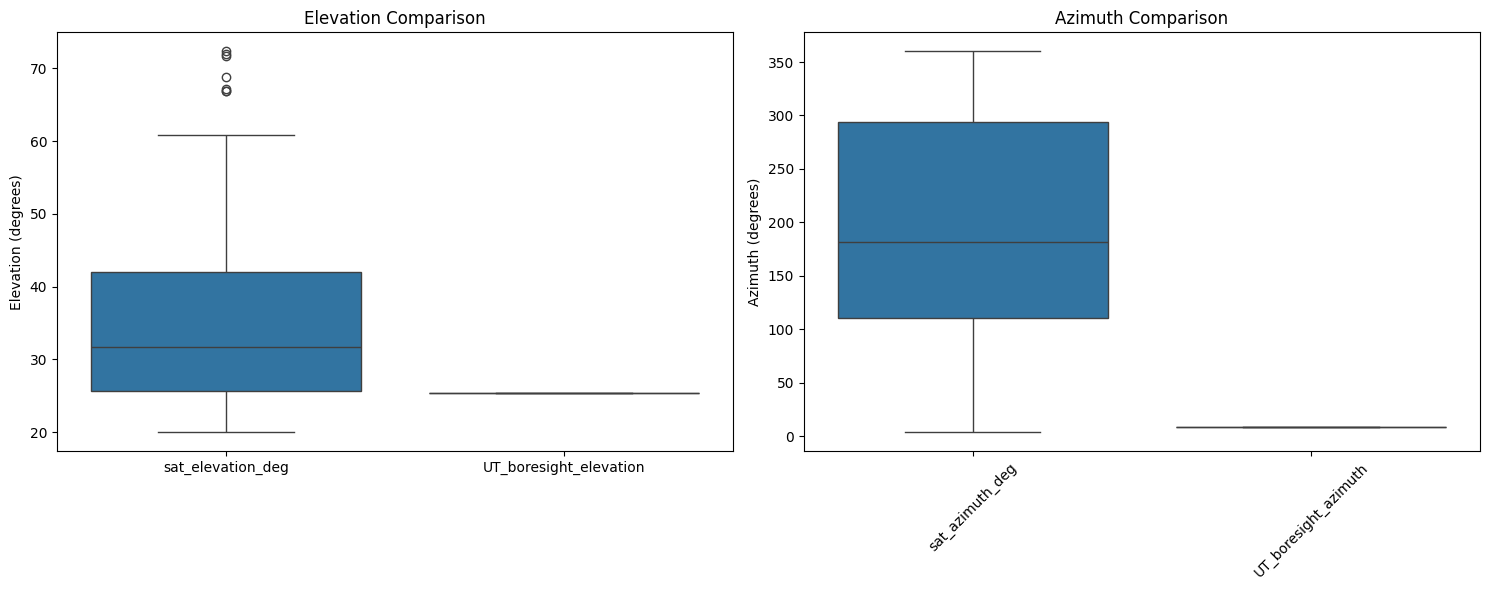

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Convert satellites data to DataFrame
satellites_df = pd.DataFrame(satellites)

# First check available columns
print("Available columns:", satellites_df.columns.tolist())

# Calculate correlation matrix for the specified features
# Only use columns that exist in the DataFrame
numeric_cols = ['sat_elevation_deg', 'sat_azimuth_deg', 'UT_boresight_elevation', 'UT_boresight_azimuth']
correlation_matrix = satellites_df[numeric_cols].corr()

# Plot correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

# Calculate basic statistics
print("\nBasic Statistics:")
print(satellites_df[numeric_cols].describe())

# Calculate pairwise correlations with p-values
print("\nPairwise Correlations with P-values:")
for i in range(len(numeric_cols)):
    for j in range(i+1, len(numeric_cols)):
        col1, col2 = numeric_cols[i], numeric_cols[j]
        correlation, p_value = stats.pearsonr(satellites_df[col1], satellites_df[col2])
        print(f"{col1} vs {col2}:")
        print(f"Correlation: {correlation:.3f}, P-value: {p_value:.3e}")

# Plot elevation vs azimuth scatter
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(data=satellites_df, 
                         x='sat_elevation_deg', 
                         y='sat_azimuth_deg',
                         hue='UT_boresight_elevation',
                         palette='viridis')
plt.title('Elevation vs Azimuth (colored by UT Boresight Elevation)')
plt.xlabel('Elevation (degrees)')
plt.ylabel('Azimuth (degrees)')
plt.colorbar(scatter.collections[0], label='UT Boresight Elevation (degrees)')
plt.show()

# Create histograms for all numeric features
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for idx, col in enumerate(numeric_cols):
    sns.histplot(data=satellites_df, x=col, ax=axes[idx])
    axes[idx].set_title(f'{col} Distribution')
    
plt.tight_layout()
plt.show()

# Additional analysis plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Elevation comparison
sns.boxplot(data=satellites_df[['sat_elevation_deg', 'UT_boresight_elevation']], ax=ax1)
ax1.set_title('Elevation Comparison')
ax1.set_ylabel('Elevation (degrees)')
plt.xticks(rotation=45)

# Azimuth comparison
sns.boxplot(data=satellites_df[['sat_azimuth_deg', 'UT_boresight_azimuth']], ax=ax2)
ax2.set_title('Azimuth Comparison')
ax2.set_ylabel('Azimuth (degrees)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
